# import library, load data

In [2]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
filepath = 'data/train.csv'
df = pd.read_csv(filepath)

# EDA

In [36]:
def info(df):
    type_list = df.dtypes
    df_stat = pd.DataFrame(type_list, columns=["data types"])
    df_stat['Missing'] = df.isnull().sum()
    df_stat['unique'] = df.nunique()
    return df_stat.style.background_gradient(cmap='rainbow')
df_stat = info(df)
df_stat

,data types,Missing,unique
PassengerId,object,0,8693
HomePlanet,object,201,3
CryoSleep,object,217,2
Cabin,object,199,6560
Destination,object,182,3
Age,float64,179,80
VIP,object,203,2
RoomService,float64,181,1273
FoodCourt,float64,183,1507
ShoppingMall,float64,208,1115


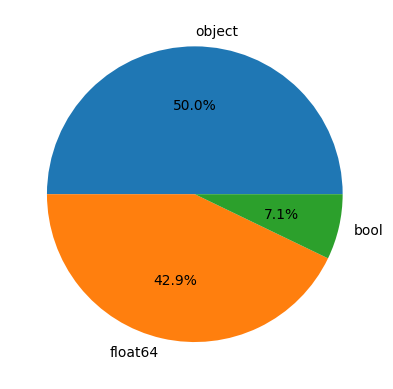

In [37]:
def plot_type_chart(df):
    df.dtypes.value_counts().plot(kind="pie",autopct='%.1f%%')
plot_type_chart(df)

C:\Users\User\AppData\Local\Temp\ipykernel_4656\944404089.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='rainbow')


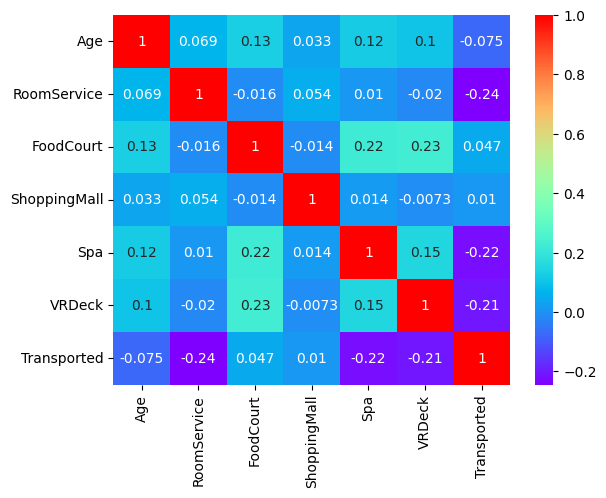

In [38]:
def plot_heat_map(df):
    sns.heatmap(df.corr(), annot=True, cmap='rainbow')
plot_heat_map(df)

['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']


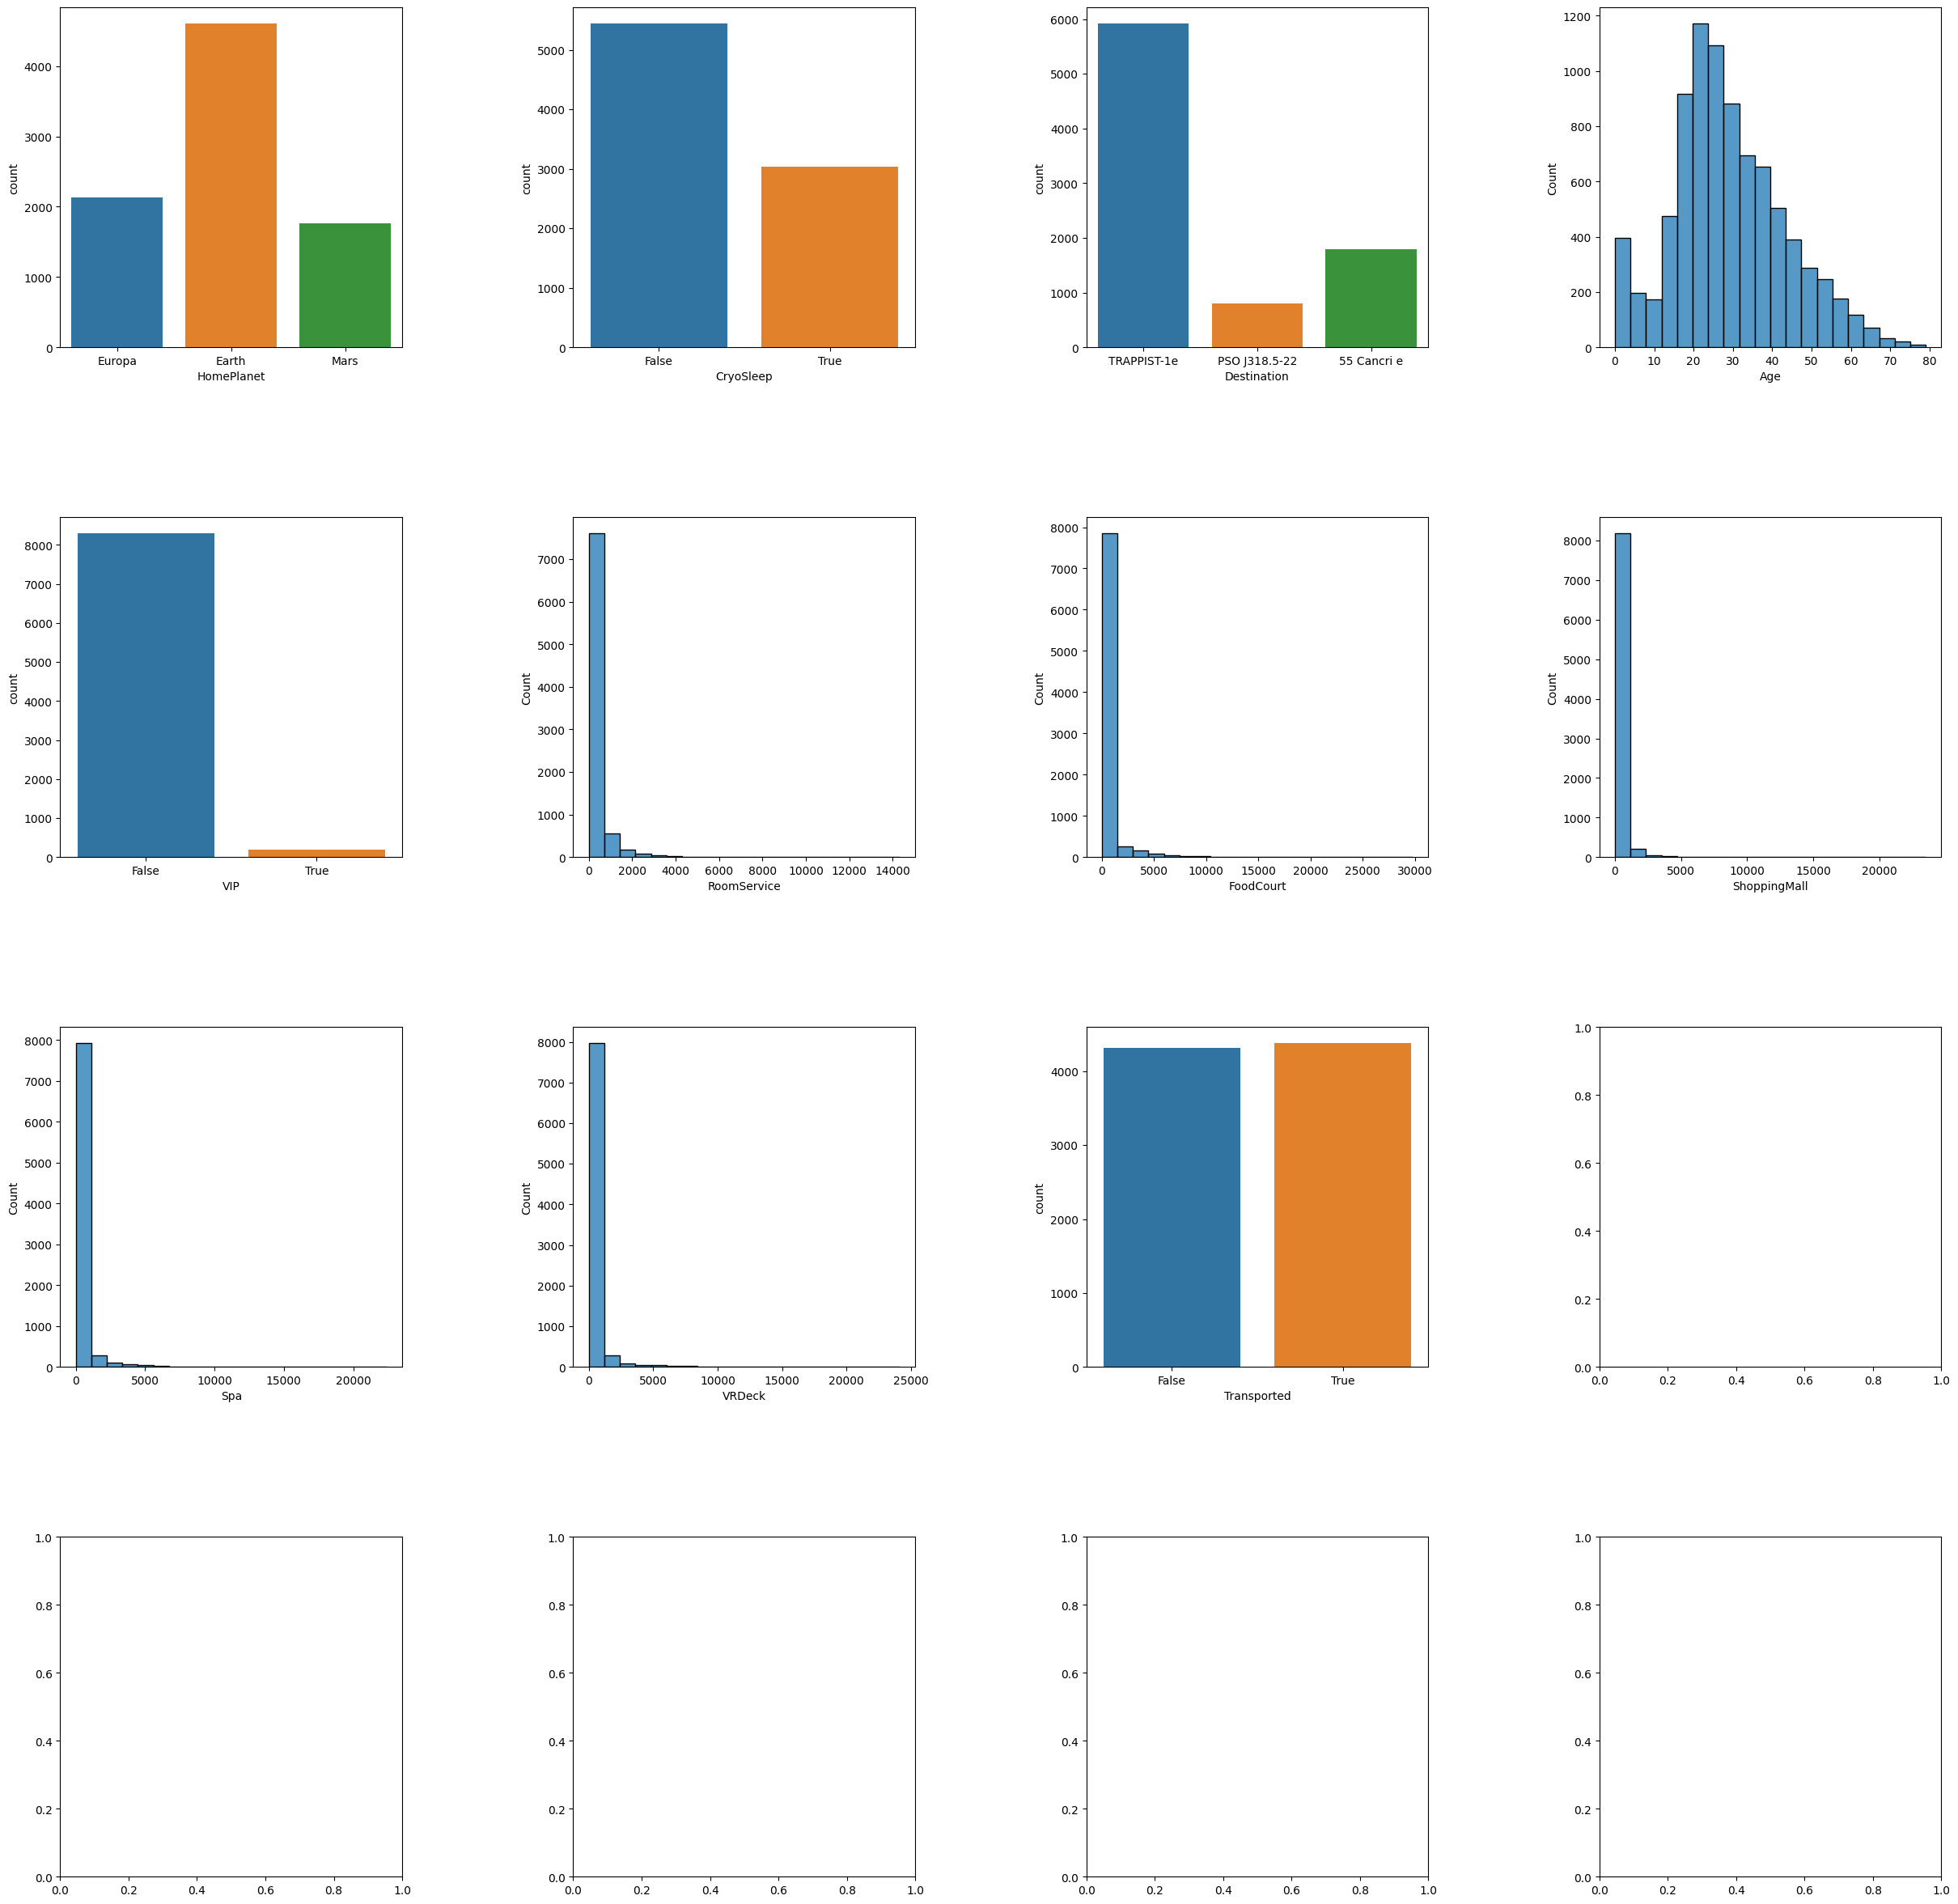

In [40]:
def plot_describe_chart(df: pd.DataFrame, filename: str, show_chart=True, rotation_xlabel_cols: list = None):
    """describe data, display: 
    * histplot: numerical features
    * barplot: categorical features
    """
    ncols = df.shape[1]
    numeric_cols = list(df.select_dtypes(include=[np.number]).columns.values)
    print(numeric_cols)

    # draw
    w = 1
    while True:
        if w**2 > ncols:
            break
        w += 1

    fig, axes = plt.subplots(w, w, figsize = (30, 30))
    for i in range(ncols):
        r = i // 4
        c = i % 4
        if df.columns[i] in numeric_cols:
            sns.histplot(ax=axes[r, c], data=df, x=df.columns[i], bins=20)
        else:
            sns.countplot(ax=axes[r, c], data=df, x=df.columns[i])
        
        # to-do
        # if rotation_xlabel_cols and df.columns[i] in rotation_xlabel_cols:
            # axes[r, c].set_xticklabels(labels = df.iloc[:,i].unique(), rotation=20)
    
    fig.subplots_adjust(wspace=0.5, hspace=0.5)
    
    fig.savefig(fname=filename)
    if show_chart:
        fig.show()

plot_describe_chart(df=df.drop(['PassengerId', 'Cabin', 'Name'],axis=1), filename='describe-test', rotation_xlabel_cols=['Destination'], show_chart=False)

# data preprocessing

In [3]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
def preprocessing(df:pd.DataFrame, target:str, drop_cols:list, encoding:str):
    # drop
    df.drop(drop_cols, axis=1, inplace=True)
    
    # filling missing value
    numeric_cols = list(df.select_dtypes(include=[np.number]).columns.values)
    imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
    imp_most = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
    for (i, col) in enumerate(df.columns):
        if col == target: continue
        if col in numeric_cols:
            df[col] = imp_median.fit_transform(df[col].values.reshape(-1,1))[:,0]
        else:
            df[col] = imp_most.fit_transform(df[col].values.reshape(-1,1))[:,0]
    # encoding
    category = None
    if encoding == 'one-hot':
        # to-do
        # warning: if number of categories in a feature exceed 10
        df = pd.get_dummies(df)
        for i in range(df.shape[1]-1, -1, -1):
            col = df.columns[i]
            if col not in numeric_cols and col != target:
                cate_now = col.split('_')[0]
                if cate_now != category:
                    category = cate_now
                    df.drop([col], axis=1, inplace=True)
    elif encoding == 'frequence':
        print('Not implement yet. please use `one-hot`. Let `encoding = one-hot`')
        pass
    # standarization
    print(df.columns)
    df.loc[:,numeric_cols] = StandardScaler().fit_transform(df.loc[:,numeric_cols])
    return df

In [ ]:
df_copy = df.copy()
df_copy = preprocessing(df_copy, 'Transported', ['PassengerId', 'Cabin', 'Name'], encoding='one-hot')

In [42]:
df_info = info(df_copy)
df_info

,data types,Missing,unique
Age,float64,0,80
RoomService,float64,0,1273
FoodCourt,float64,0,1507
ShoppingMall,float64,0,1115
Spa,float64,0,1327
VRDeck,float64,0,1306
Transported,bool,0,2
HomePlanet_Earth,uint8,0,2
HomePlanet_Europa,uint8,0,2
CryoSleep_False,uint8,0,2


# training

In [3]:
import os.path
from datetime import date
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from category_encoders.target_encoder import TargetEncoder 
from mlxtend.feature_selection import SequentialFeatureSelector
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
sns.set(style="darkgrid") # darkgrid
class Pipeline:
    def __init__(self,
                df:pd.DataFrame,
                model:list,
                model_name: list,
                encoding_list:list,
                drop_cols:list,
                target_col:str,
                validation:str,
                dir_path_dict: dict,
                baseline = False,
                random_state = 42,
                feature_select_method:str=None,
                feature_select_model=None,
                ) -> None:
        self.df = df
        self.model = model
        self.model_name = model_name
        self.encoding_list = encoding_list
        self.drop_cols = drop_cols
        self.target_col = target_col
        self.baseline = baseline 
        self.dir_path_dict = dir_path_dict
        self.random_state = random_state
        self.validation = validation
        
        self.feature_select_method = feature_select_method
        self.feature_select_model = feature_select_model

        self.train_X = None
        self.train_Y = None
        self.test_X = None
        self.test_Y = None

        self.train_score = None
        self.test_score = None 
        self.cross_val_score_list = None

    def preprocessing(self, df:pd.DataFrame, encoding:str, model, feature_select_method:str=None, feature_select_model=None, imgpath:str=None): # new df
        # define: 
        target_col = self.target_col
        drop_cols = self.drop_cols 
        
        df.drop(drop_cols, axis=1, inplace=True)
        numeric_cols = list(df.select_dtypes(include=[np.number]).columns.values)
        if self.baseline:
            df = df.dropna()
            if str(model.__class__) == "<class 'xgboost.sklearn.XGBClassifier'>" and encoding == 'none':
                for col in df.columns:
                    if col not in numeric_cols:
                        df[col] = df[col].astype('category')
            else:
                df = self.encoding(df, target_col, encoding, numeric_cols)
        else:
            df = self.filling(df, numeric_cols)
            df = self.encoding(df, target_col, encoding, numeric_cols)
            if feature_select_method:
                selected_features = self.feature_selection(df, feature_select_model, imgpath=imgpath)
                for col in df.columns:
                    if col == target_col: continue
                    if col not in selected_features:
                        df.drop(col, axis=1, inplace=True)
            df = self.standarization(df, numeric_cols)
        return df
    
    def standarization(self, df:pd.DataFrame, numeric_cols:list):
        self.df.loc[:,numeric_cols] = StandardScaler().fit_transform(df.loc[:,numeric_cols])
        return df

    def encoding(self, df:pd.DataFrame, target_col:str, encoding:str, numeric_cols:list):
        target = self.target_col

        category = None
        if encoding == 'one-hot':
            # to-do
            # warning: if number of categories in a feature exceed 10
            df = pd.get_dummies(df)
            for i in range(df.shape[1]-1, -1, -1):
                col = df.columns[i]
                if col not in numeric_cols and col != target:
                    cate_now = col.split('_')[0]
                    if cate_now != category:
                        category = cate_now
                        df.drop([col], axis=1, inplace=True)
        elif encoding == 'target':
            cols = []
            for col in df.columns:
                if col == target_col: continue
                if col not in numeric_cols:
                    cols.append(col)

            data, target = df.drop([target_col], axis=1), df[target_col]
            encoder = TargetEncoder(cols=cols).fit(data, target)
            data = encoder.transform(data)
            df = data
            df[target_col] = target
        elif encoding == 'frequence':
            print('Not implement yet. please use `one-hot`. Let `encoding = one-hot`')
            pass

        return df

    def filling(self, df:pd.DataFrame, numeric_cols:list):
        target = self.target_col

        imp_median = SimpleImputer(missing_values = np.nan, strategy='median')
        imp_most = SimpleImputer(missing_values = np.nan, strategy='most_frequent')
        for (i, col) in enumerate(df.columns):
            if col == target: continue
            if col in numeric_cols:
                df[col] = imp_median.fit_transform(df[col].values.reshape(-1,1))[:,0]
            else:
                df[col] = imp_most.fit_transform(df[col].values.reshape(-1,1))[:,0]

        return df
    
    def feature_selection(self, df:pd.DataFrame, model, imgpath:str):
        if self.feature_select_method == 'SFS':
            k_features = df.drop([self.target_col], axis=1).shape[1]
            sfs = SequentialFeatureSelector(model,
                k_features=k_features, 
                forward=True, 
                floating=False,
                scoring='accuracy',
                cv=5)
            
            train_X, test_X, train_Y, test_Y = self.split_data(df)
            sfs.fit(train_X, train_Y)


            fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
            plt.ylim(0.5, 1)
            plt.yticks(np.linspace(0.5, 1, num = round((1 - 0.5)/0.05)+1))
            plt.title('Sequential Forward Selection (w. StdDev)')
            plt.savefig(fname = imgpath)
            plt.cla()

            max_score = 0
            features = []
            for i in range(1, k_features+1):
                s = sfs.subsets_[i]
                n_features = i
                feature_names = s['feature_names']
                score = s['avg_score']
                print('n-featrues: ', n_features)
                print('feature names: ', feature_names)
                print('cv scores:', s['cv_scores'])
                print('avg score: ', score)
                print('-'*20)

                s = round(score, 3) 
                if s > max_score:
                    max_score = s
                    features = feature_names

            print('selected features: ')
            print(features)
            return features
        else:
            print('Not implemented yet.')


    def split_data(self, df:pd.DataFrame):
        target_col = self.target_col 
        random_state = self.random_state
        data, target = df.drop([target_col],axis=1), df[target_col]
        train_X, test_X, train_Y, test_Y = train_test_split(data, target, random_state = random_state)
        self.train_X = train_X
        self.train_Y = train_Y 
        self.test_X = test_X 
        self.test_Y = test_Y
        return train_X, test_X, train_Y, test_Y

    def train(self, model):
        print('training...')
        model.fit(self.train_X, self.train_Y)
        
    def score(self, model, train=True):
        if train:
            train_X, train_Y = self.train_X, self.train_Y
            pred = model.predict(train_X)
            result = {
                'acc': accuracy_score(train_Y, pred),
                'precision': precision_score(train_Y, pred),
                'recall': recall_score(train_Y, pred),
                'F1': f1_score(train_Y, pred),
                'confusion matrix':confusion_matrix(train_Y, pred)
            }
        elif train == False:
            test_X, test_Y = self.test_X, self.test_Y
            pred = model.predict(test_X)
            result = {
                'acc': accuracy_score(test_Y, pred),
                'precision': precision_score(test_Y, pred),
                'recall': recall_score(test_Y, pred),
                'F1': f1_score(test_Y, pred),
                'confusion matrix':confusion_matrix(test_Y, pred)
            }
        return pd.Series(result)
    
    def cross_validation(self, X, Y, model, scoring:str, fold=10):
        return cross_val_score(model, X, Y, cv=fold, scoring=scoring)
    
    def plot_learning_curve(self, X, Y, model, filepath:str):
        # check bias and variance of data
        # https://martychen920.blogspot.com/2017/11/ml.html
        # https://medium.com/ai%E5%8F%8D%E6%96%97%E5%9F%8E/learning-model-%E5%AD%B8%E7%BF%92%E6%9B%B2%E7%B7%9A%E8%A8%BA%E6%96%B7%E6%A8%A1%E5%9E%8B%E7%9A%84%E5%81%8F%E5%B7%AE%E5%92%8C%E6%96%B9%E5%B7%AE-%E4%B8%A6%E5%84%AA%E5%8C%96%E6%A8%A1%E5%9E%8B-47e472507923
        # https://blog.csdn.net/vincent_duan/article/details/121270138
        train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(model, X, Y, cv=10,return_times=True)
        df = pd.DataFrame(
            {
                'train size': train_sizes,
                'train': np.mean(train_scores,axis=1),
                'val': np.mean(test_scores, axis=1)
            }
        )
        plt.ylim(0.65, 1)
        plt.yticks(np.linspace(0.65, 1, num = round((1 - 0.65)/0.05)+1))
        sns.lineplot(data = pd.melt(df, ['train size'], value_name='score'), x='train size', y='score', hue='variable')

        plt.savefig(fname=filepath)
        plt.cla()
    
    def run(self):
        train_score_list = []
        test_score_list = []
        cross_val_score_list = []
        current = datetime.now()
        name = '{} {}h {}min {}sec'.format(str(date.today()), current.hour, current.minute, current.second)
        dir_path_lr_curve = os.path.join(self.dir_path_dict['image'], 'learning-curve', name)
        try:
            os.makedirs(dir_path_lr_curve)
        except Exception as e:
            print(e)
        
        dir_path_feature_select = os.path.join(self.dir_path_dict['image'], 'feature-selection')
        try:
            os.makedirs(dir_path_feature_select)
        except Exception as e:
            print(e)

        feature_selected = False
        for i in range(len(self.model)):
            m = self.model[i]
            e = self.encoding_list[i]
            m_name = self.model_name[i]
            if not feature_selected: 
                df = self.preprocessing(
                    df=self.df.copy(),
                    encoding=e,
                    model=m,
                    feature_select_method=self.feature_select_method,
                    feature_select_model=self.feature_select_model,
                    imgpath=os.path.join(dir_path_feature_select, name))
            else:
                df = self.preprocessing(df=self.df.copy(), encoding=e, model=m)
            print(df.columns)
            self.split_data(df)
            self.train(model=m)
            train_score_list.append(self.score(model=m))
            
            test_score_list.append(self.score(model=m, train=False))
            if self.validation == 'cross_validation':
                # to-do... scoring
                cross_val_score_list.append(self.cross_validation(self.test_X, self.test_Y, model=m, scoring='accuracy'))
                filepath = os.path.join(dir_path_lr_curve, m_name)
                self.plot_learning_curve(self.train_X, self.train_Y, model=m, filepath=filepath)

        self.train_score = pd.DataFrame(train_score_list, index=self.model_name)
        self.test_score = pd.DataFrame(test_score_list, index=self.model_name)

TypeError: Pipeline.__init__() missing 8 required positional arguments: 'df', 'model', 'model_name', 'encoding_list', 'drop_cols', 'target_col', 'validation', and 'dir_path_dict'

In [37]:
# Test function faeture selection 
from category_encoders.target_encoder import TargetEncoder 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

drop_cols = ['Cabin', 'Name', 'PassengerId']
target_col = 'Transported'
validation = 'cross_validation'
dir_path_dict = {'image':'image', 'model':'model', 'submission':'submission'}
pipeline = Pipeline(
    df=df,
    model=[rf],
    model_name=['rf'],
    encoding_list=['target'],
    drop_cols=drop_cols,
    target_col=target_col,
    validation=validation,
    dir_path_dict=dir_path_dict,
    baseline=False,
    random_state=42,
    feature_select_method='SFS',
    feature_select_model=rf
)
# vars(pipeline)
for v in vars(pipeline):
    print(v)
# pipeline.run()

df
model
model_name
encoding_list
drop_cols
target_col
baseline
dir_path_dict
random_state
validation
feature_select_method
feature_select_model
train_X
train_Y
test_X
test_Y
train_score
test_score
cross_val_score_list


Index(['HomePlanet', 'CryoSleep', 'Destination', 'Age', 'VIP', 'RoomService',
       'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Transported'],
      dtype='object')
training...


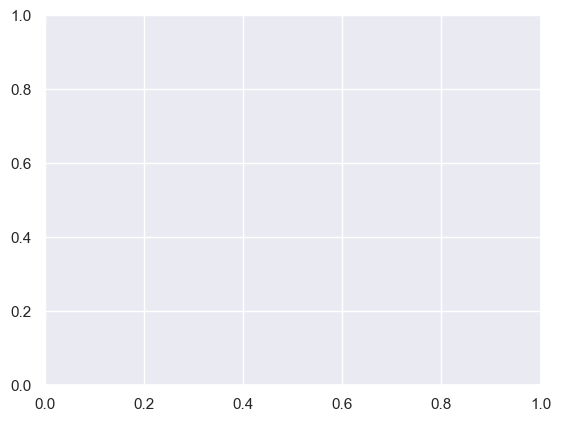

In [11]:
from category_encoders.target_encoder import TargetEncoder 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()

drop_cols = ['Cabin', 'Name', 'PassengerId']
target_col = 'Transported'
validation = 'cross_validation'
dir_path_dict = {'image':'image', 'model':'model', 'submission':'submission'}

pipeline = Pipeline(
    df,
    model = [rf],
    model_name = ['rf'],
    encoding_list = ['target'],
    drop_cols = drop_cols,
    target_col = target_col, 
    validation = validation,
    dir_path_dict = dir_path_dict,
    baseline=False)

pipeline.run()

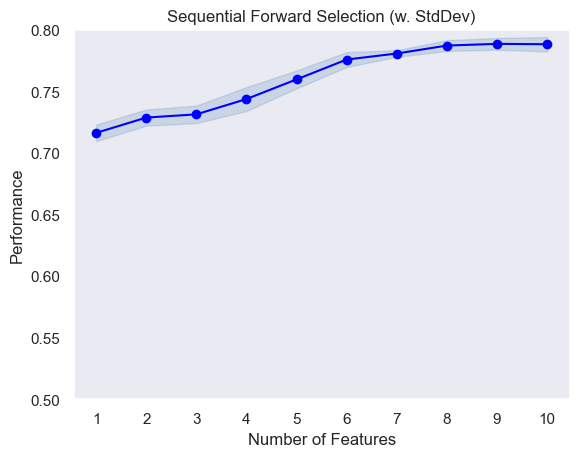

n-featrues:  5
feature names:  ('CryoSleep', 'Age', 'FoodCourt', 'Spa', 'VRDeck')
cv scores: [0.74616564 0.76763804 0.75996933 0.7607362  0.76362241]
avg score:  0.7596263224554944
--------------------
n-featrues:  6
feature names:  ('CryoSleep', 'Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck')
cv scores: [0.76840491 0.77453988 0.77530675 0.78680982 0.77359939]
avg score:  0.7757321471450969
--------------------
n-featrues:  7
feature names:  ('HomePlanet', 'CryoSleep', 'Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck')
cv scores: [0.77684049 0.77990798 0.78067485 0.78527607 0.78050652]
avg score:  0.7806411819821177
--------------------
n-featrues:  8
feature names:  ('HomePlanet', 'CryoSleep', 'Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck')
cv scores: [0.78220859 0.78297546 0.78757669 0.78834356 0.7943208 ]
avg score:  0.7870850185273249
--------------------
n-featrues:  9
feature names:  ('HomePlanet', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 

<Figure size 640x480 with 0 Axes>

In [16]:
# after target encoding and feature selection
from mlxtend.feature_selection import SequentialFeatureSelector
from xgboost import XGBClassifier
xgb = XGBClassifier()
pipeline = Pipeline(
    df,
    model = [xgb],
    model_name = ['xgb'],
    encoding_list = ['target'],
    drop_cols = drop_cols,
    target_col = target_col, 
    validation = validation,
    dir_path_dict = dir_path_dict,
    baseline=False)

sfs = SequentialFeatureSelector(xgb, 
           k_features=10, 
           forward=True, 
           floating=False,
           scoring='accuracy',
           cv=5)

df_copy = pipeline.preprocessing(df.copy(), encoding='target', model=xgb)
# featrue selection 
train_X, test_X, train_Y, test_Y = pipeline.split_data(df_copy)
sfs.fit(train_X, train_Y)

from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs


fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.ylim([0.5, 0.8])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
plt.savefig(fname = 'Sequential Forward Selection.png')

max_score = 0
features = []
for i in range(5, 11):
    s = sfs.subsets_[i]
    n_features = i
    feature_names = s['feature_names']
    score = s['avg_score']
    print('n-featrues: ', n_features)
    print('feature names: ', feature_names)
    print('cv scores:', s['cv_scores'])
    print('avg score: ', score)
    print('-'*20)

    s = round(score, 3) 
    if s > max_score:
        max_score = s
        features = feature_names

print('selected features: ')
print(features)
### discard Destination

Index(['HomePlanet', 'CryoSleep', 'Age', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Transported'],
      dtype='object')
training...
Index(['HomePlanet', 'CryoSleep', 'Age', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Transported'],
      dtype='object')
training...
Index(['HomePlanet', 'CryoSleep', 'Age', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Transported'],
      dtype='object')
training...
Index(['HomePlanet', 'CryoSleep', 'Age', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Transported'],
      dtype='object')
training...
Index(['HomePlanet', 'CryoSleep', 'Age', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Transported'],
      dtype='object')
training...


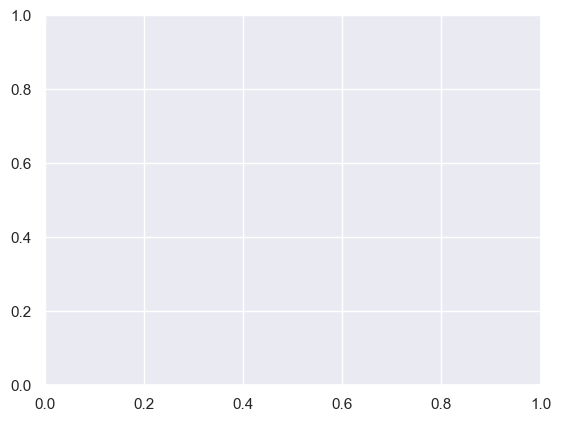

In [18]:
# test for after feature selection and encoding 
# Test for pipeline
from xgboost import XGBClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

xgb = XGBClassifier()
svc = SVC()
knn = KNeighborsClassifier()
lr = LogisticRegressionCV()
rf = RandomForestClassifier()
model = [xgb, svc, knn, lr, rf]
model_name = ['xgb', 'svc', 'knn', 'lr', 'rf']
encoding_list = ['target', 'target', 'target', 'target', 'target']
drop_cols = ['Cabin', 'Name', 'PassengerId', 'Destination']
target_col = 'Transported'
validation = 'cross_validation'
dir_path_dict = {'image':'image', 'model':'model', 'submission':'submission'}

pipeline = Pipeline(
    df,
    model,
    model_name,
    encoding_list,
    drop_cols,
    target_col, 
    validation,
    dir_path_dict,
    baseline=False)
pipeline.run()

# 改善overfitting的問題


,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported
0,0.658846,0.335042,0.472199,0.711945,0.506475,-0.333105,-0.281027,-0.283579,-0.270626,-0.263003,False
1,0.427649,0.335042,0.472199,-0.334037,0.506475,-0.168073,-0.275387,-0.241771,0.217158,-0.224205,True
2,0.658846,0.335042,0.472199,2.036857,0.381910,-0.268001,1.959998,-0.283579,5.695623,-0.219796,False
3,0.658846,0.335042,0.472199,0.293552,0.506475,-0.333105,0.523010,0.336851,2.687176,-0.092818,False
4,0.427649,0.335042,0.472199,-0.891895,0.506475,0.125652,-0.237159,-0.031059,0.231374,-0.261240,True


n-featrues:  5
feature names:  ('HomePlanet', 'CryoSleep', 'Age', 'VIP', 'FoodCourt')
cv scores: [0.69861963 0.72546012 0.72546012 0.72929448 0.74213354]
avg score:  0.7241935787634952
--------------------
n-featrues:  6
feature names:  ('HomePlanet', 'CryoSleep', 'Age', 'VIP', 'FoodCourt', 'ShoppingMall')
cv scores: [0.73773006 0.7392638  0.75996933 0.74769939 0.76592479]
avg score:  0.7501174731271394
--------------------
n-featrues:  7
feature names:  ('HomePlanet', 'CryoSleep', 'Age', 'VIP', 'FoodCourt', 'ShoppingMall', 'VRDeck')
cv scores: [0.75383436 0.75230061 0.75996933 0.77453988 0.77052955]
avg score:  0.7622347437955825
--------------------
n-featrues:  8
feature names:  ('HomePlanet', 'CryoSleep', 'Age', 'VIP', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck')
cv scores: [0.77300613 0.79754601 0.77223926 0.79447853 0.79125096]
avg score:  0.7857041795949884
--------------------
n-featrues:  9
feature names:  ('HomePlanet', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 

In [4]:
# feature selection 
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# xgb = XGBClassifier(tree_method="hist", enable_categorical=True)
rf = RandomForestClassifier()
xgb = XGBClassifier()

drop_cols = ['Cabin', 'Name', 'PassengerId']
target_col = 'Transported'
validation = 'cross_validation'
dir_path_dict = {'image':'image', 'model':'model', 'submission':'submission'}

sfs = SequentialFeatureSelector(rf, 
           k_features=6, 
           forward=True, 
           floating=False,
           scoring='accuracy',
           cv=2)

utility = Pipeline(
    df,
    model = [rf],
    model_name = ['rf'],
    encoding_list = ['one-hot'],
    drop_cols = drop_cols,
    target_col = target_col, 
    validation = validation,
    dir_path_dict = dir_path_dict,
    baseline=True)

df_copy = utility.preprocessing(df.copy(), 'one-hot', rf)
print(df_copy.columns)
print(df_copy.info())
train_X, test_X, train_Y, test_Y = utility.split_data(df_copy)

sfs.fit(train_X, train_Y)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'CryoSleep_False', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'VIP_False'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6923 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        6923 non-null   float64
 1   RoomService                6923 non-null   float64
 2   FoodCourt                  6923 non-null   float64
 3   ShoppingMall               6923 non-null   float64
 4   Spa                        6923 non-null   float64
 5   VRDeck                     6923 non-null   float64
 6   Transported                6923 non-null   bool   
 7   HomePlanet_Earth           6923 non-null   uint8  
 8   HomePlanet_Europa          6923 non-null   uint8  
 9   CryoSleep

SequentialFeatureSelector(cv=2, estimator=RandomForestClassifier(),
                          k_features=(6, 6), scoring='accuracy')

In [18]:
# feature selection 
from mlxtend.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
# xgb = XGBClassifier(tree_method="hist", enable_categorical=True)
rf = RandomForestClassifier()
xgb = XGBClassifier()

drop_cols = ['Cabin', 'Name', 'PassengerId']
target_col = 'Transported'
validation = 'cross_validation'
dir_path_dict = {'image':'image', 'model':'model', 'submission':'submission'}

sbs = SequentialFeatureSelector(rf, 
           k_features=6, 
           forward=False, 
           floating=False,
           scoring='accuracy',
           cv=2)

utility = Pipeline(
    df,
    model = [rf],
    model_name = ['rf'],
    encoding_list = ['one-hot'],
    drop_cols = drop_cols,
    target_col = target_col, 
    validation = validation,
    dir_path_dict = dir_path_dict,
    baseline=True)

df_copy = utility.preprocessing(df.copy(), 'one-hot', rf)
print(df_copy.columns)
print(df_copy.info())
train_X, test_X, train_Y, test_Y = utility.split_data(df_copy)

sbs.fit(train_X, train_Y)

Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'CryoSleep_False', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'VIP_False'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6923 entries, 0 to 8692
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        6923 non-null   float64
 1   RoomService                6923 non-null   float64
 2   FoodCourt                  6923 non-null   float64
 3   ShoppingMall               6923 non-null   float64
 4   Spa                        6923 non-null   float64
 5   VRDeck                     6923 non-null   float64
 6   Transported                6923 non-null   bool   
 7   HomePlanet_Earth           6923 non-null   uint8  
 8   HomePlanet_Europa          6923 non-null   uint8  
 9   CryoSleep

SequentialFeatureSelector(cv=2, estimator=RandomForestClassifier(),
                          forward=False, k_features=(6, 6), scoring='accuracy')

In [19]:
sbs.get_metric_dict()

{12: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11),
  'cv_scores': array([0.78120185, 0.78428351]),
  'avg_score': 0.7827426810477658,
  'feature_names': ('Age',
   'RoomService',
   'FoodCourt',
   'ShoppingMall',
   'Spa',
   'VRDeck',
   'HomePlanet_Earth',
   'HomePlanet_Europa',
   'CryoSleep_False',
   'Destination_55 Cancri e',
   'Destination_PSO J318.5-22',
   'VIP_False'),
  'ci_bound': 0.006629665223284092,
  'std_dev': 0.0015408320493066618,
  'std_err': 0.0015408320493066616},
 11: {'feature_idx': (0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11),
  'cv_scores': array([0.78890601, 0.78736518]),
  'avg_score': 0.788135593220339,
  'feature_names': ('Age',
   'RoomService',
   'FoodCourt',
   'ShoppingMall',
   'Spa',
   'VRDeck',
   'HomePlanet_Earth',
   'HomePlanet_Europa',
   'CryoSleep_False',
   'Destination_PSO J318.5-22',
   'VIP_False'),
  'ci_bound': 0.003314832611642046,
  'std_dev': 0.0007704160246533309,
  'std_err': 0.0007704160246533308},
 10: {'feature_idx': (0, 1

In [5]:
sfs.get_metric_dict()

{1: {'feature_idx': (8,),
  'cv_scores': array([0.72688752, 0.70993837]),
  'avg_score': 0.7184129429892141,
  'feature_names': ('CryoSleep_False',),
  'ci_bound': 0.036463158728061794,
  'std_dev': 0.008474576271186474,
  'std_err': 0.008474576271186474},
 2: {'feature_idx': (0, 8),
  'cv_scores': array([0.73382126, 0.71109399]),
  'avg_score': 0.722457627118644,
  'feature_names': ('Age', 'CryoSleep_False'),
  'ci_bound': 0.04889378102171898,
  'std_dev': 0.011363636363636354,
  'std_err': 0.011363636363636352},
 3: {'feature_idx': (0, 8, 11),
  'cv_scores': array([0.73382126, 0.70878274]),
  'avg_score': 0.7213020030816641,
  'feature_names': ('Age', 'CryoSleep_False', 'VIP_False'),
  'ci_bound': 0.05386602993918181,
  'std_dev': 0.012519260400616294,
  'std_err': 0.012519260400616293},
 4: {'feature_idx': (0, 2, 8, 11),
  'cv_scores': array([0.73151002, 0.70993837]),
  'avg_score': 0.7207241910631741,
  'feature_names': ('Age', 'FoodCourt', 'CryoSleep_False', 'VIP_False'),
  'ci_bo

In [34]:
# fig1, axes1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
import matplotlib
# matplotlib.use('agg')
fig2, axes2 = plot_sfs(sbs.get_metric_dict(), kind='std_dev')
# plt.savefig(fname = 'test.png')
# fig2.legend()
# fig2.show()

<Figure size 640x480 with 0 Axes>

In [59]:
encoded_train = encoder.transform(train_X)
encoded_train['Destination']

2870    0.476631
1559    0.476631
132     0.476631
4148    0.606181
517     0.476631
          ...   
5729    0.606181
5913    0.476631
940     0.476631
8349    0.606181
7979    0.476631
Name: Destination, Length: 5934, dtype: float64

In [ ]:
# Test for pipeline
from xgboost import XGBClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier

xgb = XGBClassifier(tree_method="hist", enable_categorical=True)
svc = SVC()
knn = KNeighborsClassifier()
lr = LogisticRegressionCV()
model = [xgb, svc, knn, lr]
model_name = ['xgb', 'svc', 'knn', 'lr']
encoding_list = ['none', 'one-hot', 'one-hot', 'one-hot']
drop_cols = ['Cabin', 'Name', 'PassengerId']
target_col = 'Transported'
validation = 'cross_validation'
dir_path_dict = {'image':'image', 'model':'model', 'submission':'submission'}

baseline_pipeline = Pipeline(
    df,
    model,
    model_name,
    encoding_list,
    drop_cols,
    target_col, 
    validation,
    dir_path_dict,
    baseline=True)
baseline_pipeline.run()
# logistic fails to converge


Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'CryoSleep_False', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'VIP_False'],
      dtype='object')
training...
Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'CryoSleep_False', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'VIP_False'],
      dtype='object')
training...
Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'CryoSleep_False', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'VIP_False'],
      dtype='object')
training...
Index(['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'CryoSleep_False', 'Destinatio

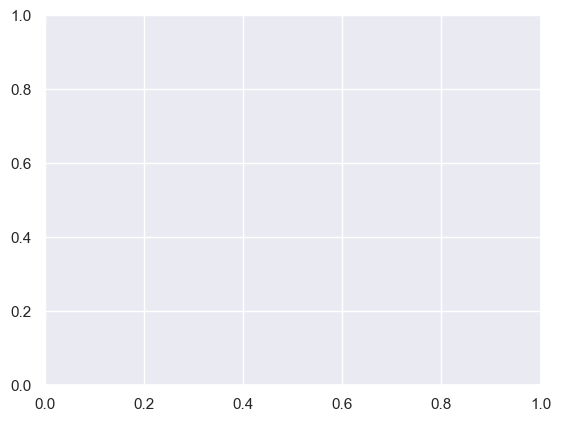

In [106]:
# Test normal 
xgb = XGBClassifier()
svc = SVC()
knn = KNeighborsClassifier()
lr = LogisticRegressionCV()
rf = RandomForestClassifier()
model = [xgb, svc, knn, lr, rf]
model_name = ['xgb', 'svc', 'knn', 'lr', 'rf']
encoding_list = ['one-hot', 'one-hot', 'one-hot', 'one-hot', 'one-hot']
drop_cols = ['Cabin', 'Name', 'PassengerId']
target_col = 'Transported'
validation = 'cross_validation'
dir_path_dict = {'image':'image', 'model':'model', 'submission':'submission'}
pipeline = Pipeline(
    df,
    model,
    model_name,
    encoding_list,
    drop_cols,
    target_col, 
    validation,
    dir_path_dict)
pipeline.run()

In [101]:
# feature selection
# 卡方检验
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
iris = load_iris()
X, y = iris.data, iris.target  #iris数据集

#选择K个最好的特征，返回选择特征后的数据
X_new = SelectKBest(chi2, k=2).fit_transform(X, y)

In [39]:
sfs.subsets_

{1: {'feature_idx': (8,),
  'cv_scores': array([0.75400168, 0.72030329, 0.73125527, 0.70008425, 0.70910624]),
  'avg_score': 0.7229501442694962,
  'feature_names': ('CryoSleep_False',)},
 2: {'feature_idx': (0, 8),
  'cv_scores': array([0.76748104, 0.72283067, 0.74641955, 0.71019377, 0.72259696]),
  'avg_score': 0.7339043971296693,
  'feature_names': ('Age', 'CryoSleep_False')},
 3: {'feature_idx': (0, 2, 8),
  'cv_scores': array([0.75652906, 0.73799495, 0.7514743 , 0.70766639, 0.73102867]),
  'avg_score': 0.73693867374352,
  'feature_names': ('Age', 'FoodCourt', 'CryoSleep_False')},
 4: {'feature_idx': (0, 2, 3, 8),
  'cv_scores': array([0.75905644, 0.74389217, 0.76495366, 0.72535805, 0.75463744]),
  'avg_score': 0.7495795513794039,
  'feature_names': ('Age', 'FoodCourt', 'ShoppingMall', 'CryoSleep_False')},
 5: {'feature_idx': (0, 2, 3, 4, 8),
  'cv_scores': array([0.7767481 , 0.75821398, 0.77590564, 0.74052233, 0.77234401]),
  'avg_score': 0.7647468144925847,
  'feature_names': ('Ag

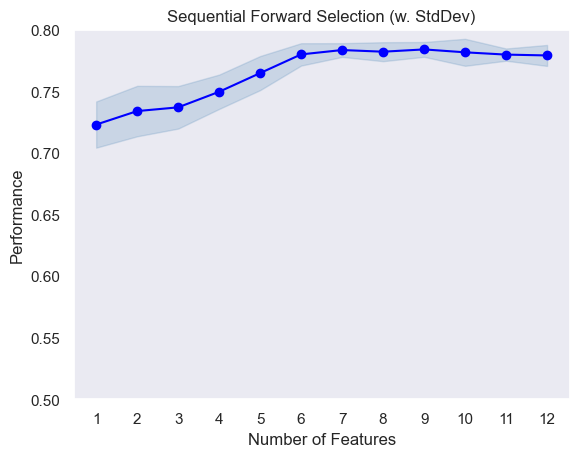

<Figure size 640x480 with 0 Axes>

In [48]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt


fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')
plt.ylim([0.5, 0.8])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()
plt.savefig(fname = 'Sequential Forward Selection.png')

In [50]:
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
# 必須停止這種悲劇繼續下去
efs1 = EFS(xgb, 
           min_features=6,
           max_features=10,
           scoring='accuracy',
           print_progress=True,
           cv=5)

efs1 = efs1.fit(train_X, train_Y)

KeyboardInterrupt: 

In [43]:
sfs.get_metric_dict()

{1: {'feature_idx': (8,),
  'cv_scores': array([0.75400168, 0.72030329, 0.73125527, 0.70008425, 0.70910624]),
  'avg_score': 0.7229501442694962,
  'feature_names': ('CryoSleep_False',),
  'ci_bound': 0.024077736475599465,
  'std_dev': 0.018733296977860865,
  'std_err': 0.009366648488930433},
 2: {'feature_idx': (0, 8),
  'cv_scores': array([0.76748104, 0.72283067, 0.74641955, 0.71019377, 0.72259696]),
  'avg_score': 0.7339043971296693,
  'feature_names': ('Age', 'CryoSleep_False'),
  'ci_bound': 0.026319919839508984,
  'std_dev': 0.02047779180932074,
  'std_err': 0.010238895904660369},
 3: {'feature_idx': (0, 2, 8),
  'cv_scores': array([0.75652906, 0.73799495, 0.7514743 , 0.70766639, 0.73102867]),
  'avg_score': 0.73693867374352,
  'feature_names': ('Age', 'FoodCourt', 'CryoSleep_False'),
  'ci_bound': 0.022172506791555385,
  'std_dev': 0.017250963556760278,
  'std_err': 0.008625481778380139},
 4: {'feature_idx': (0, 2, 3, 8),
  'cv_scores': array([0.75905644, 0.74389217, 0.76495366, 

In [51]:
max_score = 0
features = []
for i in range(5, 13):
    s = sfs.subsets_[i]
    n_features = i
    feature_names = s['feature_names']
    score = s['avg_score']
    print('n-featrues: ', n_features)
    print('feature names: ', feature_names)
    print('cv scores:', s['cv_scores'])
    print('avg score: ', score)
    print('-'*20)

    s = round(score, 3) 
    if s > max_score:
        max_score = s
        features = feature_names

print('selected features: ')
print(features)

n-featrues:  5
feature names:  ('Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'CryoSleep_False')
cv scores: [0.7767481  0.75821398 0.77590564 0.74052233 0.77234401]
avg score:  0.7647468144925847
--------------------
n-featrues:  6
feature names:  ('Age', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CryoSleep_False')
cv scores: [0.79191238 0.7725358  0.78433024 0.76663858 0.7841484 ]
avg score:  0.7799130831336102
--------------------
n-featrues:  7
feature names:  ('Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'CryoSleep_False')
cv scores: [0.789385   0.78011794 0.78770008 0.77422072 0.78583474]
avg score:  0.7834516991977452
--------------------
n-featrues:  8
feature names:  ('Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet_Europa', 'CryoSleep_False')
cv scores: [0.77843302 0.7725358  0.7935973  0.77759056 0.78836425]
avg score:  0.7821041894270562
--------------------
n-featrues:  9
feature names:  ('Age', 'RoomService', 'FoodCour

In [54]:
columns = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck',
       'Transported', 'HomePlanet_Earth', 'HomePlanet_Europa',
       'CryoSleep_False', 'Destination_55 Cancri e',
       'Destination_PSO J318.5-22', 'VIP_False']
target_col = 'Transported'
selected_cols = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'HomePlanet_Europa', 'CryoSleep_False', 'VIP_False']
drop_cols = ['Name', 'Cabin', 'PassengerId']
for col in columns:
    if col == target_col: continue 
    if col not in selected_cols:
        drop_cols.append(col)
drop_cols

['Name',
 'Cabin',
 'PassengerId',
 'HomePlanet_Earth',
 'Destination_55 Cancri e',
 'Destination_PSO J318.5-22']

In [46]:
import os
from datetime import date
dir_path = os.path.join('image', 'learning-curve', str(date.today()))
print(dir_path)
try:
    os.makedirs(dir_path)
except Exception as e :
    print(e)
    pass 

image\learning-curve\2023-04-04
[WinError 183] 當檔案已存在時，無法建立該檔案。: 'image\\learning-curve\\2023-04-04'


In [24]:
from sklearn.model_selection import train_test_split
def train(df:pd.DataFrame, target_col:str, model, random_state=42):
    print('training...')
    data, target = df.drop([target_col],axis=1), df[target_col]
    train_X, test_X, train_Y, test_Y = train_test_split(data, target, random_state = random_state)
    model.fit(train_X, train_Y)
    r = {
        'model': model.__class__,
        'train_X':train_X,
        'test_X':test_X,
        'train_Y':train_Y,
        'test_Y':test_Y
    }
    return r    

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
def score(model, x_train, y_train, x_test = None, y_test = None, train=True):
    if train:
        pred = model.predict(x_train)
        print(pred.shape)
        print(pred)
        result = {
            'acc': accuracy_score(y_train, pred),
            'precision': precision_score(y_train, pred),
            'recall': recall_score(y_train, pred),
            'F1': f1_score(y_train, pred),
            'confusion matrix':confusion_matrix(y_train, pred)
        }
    elif train == False:
        pred = model.predict(x_test)
        result = {
            'acc': accuracy_score(y_test, pred),
            'precision': precision_score(y_test, pred),
            'recall': recall_score(y_test, pred),
            'F1': f1_score(y_test, pred),
            'confusion matrix':confusion_matrix(y_test, pred)
        }
    return pd.Series(result)

def validation():
    pass

from xgboost import XGBClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression 
def baseline_pipeline(df:pd.DataFrame, drop_cols:list, target:str, encoding:str, model):
    print('In baseline_pipeline, encoding = {}, model = {}'.format(encoding, str(model.__class__)))
    df_dropna = df.dropna()
    df_dropna.drop(drop_cols, axis=1, inplace=True)
    numeric_cols = list(df_dropna.select_dtypes(include=[np.number]).columns.values)
    if encoding == 'one-hot':
        df_dropna = pd.get_dummies(df_dropna)
        category = None
        for i in range(df_dropna.shape[1]-1, -1, -1):
            col = df_dropna.columns[i]
            if col not in numeric_cols and col != target:
                cate_now = col.split('_')[0]
                if cate_now != category:
                    category = cate_now
                    df_dropna.drop([col], axis=1, inplace=True)
    elif encoding == 'none':
        pass
    
    if str(model.__class__) == "<class 'xgboost.sklearn.XGBClassifier'>" and encoding == 'none':
        for col in df_dropna.columns:
            if col not in numeric_cols:
                df_dropna[col] = df_dropna[col].astype('category')
                
    r = train(df_dropna, target, model)
    s = score(model, r['train_X'], r['train_Y'])
    return {
        'train':r,
        'score':s
    }

def pipeline(df:pd.DataFrame, target:str, drop_cols:list, encoding:str, model):
    df_copy = df.copy()
    df_copy = preprocessing(df_copy, target, drop_cols, encoding)
    r = train(df_copy, target, model)
    s = score(model, r['train_X'], r['train_Y'])
    return s

In [27]:
# baseline
xgb = XGBClassifier(tree_method="hist", enable_categorical=True)
svc = SVC()
knn = KNeighborsClassifier()
lr = LogisticRegression()
drop_cols = ['Cabin', 'Name', 'PassengerId']
encoding = ['none', 'one-hot', 'one-hot', 'one-hot']
model = [xgb, svc, knn, lr]
index = ['xgb', 'svc', 'knn', 'lr']
train_score_list = []
test_score_list = []

for m, e in zip(model, encoding):
    result = baseline_pipeline(df, drop_cols, 'Transported', e, m)
    train_score_list.append(result['score'])

    # print(result['train']['test_X'].shape, result['train']['test_Y'].shape)
    # s = score(m, None, None, result['train']['test_X'], result['train']['test_Y'], train=False)
    # test_score_list.append(s)

train_score_baseline = pd.DataFrame(train_score_list, index=index)
# test_score_baseline = pd.DataFrame(test_score_list, index=index)

# after processing
"""
xgb = XGBClassifier()
svc = SVC()
knn = KNeighborsClassifier()
lr = LogisticRegression()
xgb_score = baseline_pipeline(df, 'Transported', 'none', xgb)
svc_score = baseline_pipeline(df, 'Transported', 'one-hot',svc)
knn_score = baseline_pipeline(df, 'Transported', 'one-hot', knn)
lr_score = baseline_pipeline(df, 'Transported', 'one-hot', lr)
"""

In baseline_pipeline, encoding = none, model = <class 'xgboost.sklearn.XGBClassifier'>
training...
(4954,)
[1 1 0 ... 0 0 1]
In baseline_pipeline, encoding = one-hot, model = <class 'sklearn.svm._classes.SVC'>
training...


C:\Users\User\AppData\Local\Temp\ipykernel_26916\2742849191.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna.drop(drop_cols, axis=1, inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_26916\2742849191.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna[col] = df_dropna[col].astype('category')
C:\Users\User\AppData\Local\Temp\ipykernel_26916\2742849191.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

(4954,)
[ True  True False ... False False  True]
In baseline_pipeline, encoding = one-hot, model = <class 'sklearn.neighbors._classification.KNeighborsClassifier'>
training...


C:\Users\User\AppData\Local\Temp\ipykernel_26916\2742849191.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna.drop(drop_cols, axis=1, inplace=True)


(4954,)
[ True  True False ... False False  True]
In baseline_pipeline, encoding = one-hot, model = <class 'sklearn.linear_model._logistic.LogisticRegression'>
training...
(4954,)
[ True  True False ... False False False]


C:\Users\User\AppData\Local\Temp\ipykernel_26916\2742849191.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropna.drop(drop_cols, axis=1, inplace=True)
c:\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


"\nxgb = XGBClassifier()\nsvc = SVC()\nknn = KNeighborsClassifier()\nlr = LogisticRegression()\nxgb_score = baseline_pipeline(df, 'Transported', 'none', xgb)\nsvc_score = baseline_pipeline(df, 'Transported', 'one-hot',svc)\nknn_score = baseline_pipeline(df, 'Transported', 'one-hot', knn)\nlr_score = baseline_pipeline(df, 'Transported', 'one-hot', lr)\n"

In [ ]:
xgb_baseline_score

In [18]:
train_score_baseline

,acc,precision,recall,F1,confusion matrix
xgb,0.901897,0.874066,0.940113,0.905887,"[[2129, 337], [149, 2339]]"
svc,0.794711,0.751625,0.883039,0.812050,"[[1740, 726], [291, 2197]]"
knn,0.821760,0.824505,0.819534,0.822012,"[[2032, 434], [449, 2039]]"
lr,0.788050,0.778682,0.807476,0.792818,"[[1895, 571], [479, 2009]]"
